### Show how accuracy varies across mice by running LSTM on all sessions.

### Run Models

#### LSTM

In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import csv
import os
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def run_lstm_model(hidden_dim, layer_dim, learning_rate, num_epochs, batch_size, seq_len, session_details_file_path, spike_trains_file_path):
    # Function to save session details to a CSV file
    def save_session_details(session_details):
        fieldnames = [
            'session_number', 'bins', 'model_name', 'test_acc', 
            'train_acc', 'num_epochs', 'hidden_dim', 'layer_dim', 
            'learning_rate', 'batch_size'
        ]
        
        # Check if the file exists
        file_exists = os.path.isfile(session_details_file_path)
        
        # Open the file in append mode
        with open(session_details_file_path, 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            
            # Write the header if the file does not exist
            if not file_exists:
                writer.writeheader()
            
            # Write the session details
            writer.writerow(session_details)

    with open(spike_trains_file_path, 'rb') as f:
        spike_df = pickle.load(f)

    # Create X and y
    X = spike_df.drop(columns=['frame']).values
    y = spike_df['frame'].values

    # Encode categorical target values
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    output_dim = len(np.unique(y_encoded))

    # Create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=False)

    num_samples_train = X_train.shape[0] // seq_len
    num_features = X_train.shape[1]
    num_samples_test = X_test.shape[0] // seq_len

    # Reshape input and output to have 3 dimensions
    X_train = X_train[:num_samples_train*seq_len].reshape(num_samples_train, seq_len, num_features)
    y_train = y_train[:num_samples_train*seq_len].reshape(num_samples_train, seq_len, 1)[:, -1]
    X_test = X_test[:num_samples_test*seq_len].reshape(num_samples_test, seq_len, num_features)
    y_test = y_test[:num_samples_test*seq_len].reshape(num_samples_test, seq_len, 1)[:, -1]

    # Convert numpy arrays to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)

    # Define LSTM model
    class LSTMModel(nn.Module):
        def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
            super(LSTMModel, self).__init__()
            self.hidden_dim = hidden_dim
            self.layer_dim = layer_dim
            self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
            self.fc = nn.Linear(hidden_dim, output_dim)

        def forward(self, x):
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
            out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
            out = self.fc(out[:, -1, :])
            return out

    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Set model parameters
    input_dim = X_train.shape[-1]

    # Initialize the model, loss function, and optimizer
    model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoaders for training and testing data
    train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=True)

    highest_test_acc = 0.0
    best_train_acc = 0.0

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_running_loss = 0.0
        correct_train_preds = 0.0
        total_train_samples = 0.0
        for i, (features, labels) in enumerate(train_loader):
            features = features.view(-1, seq_len, input_dim).to(device)
            labels = labels.to(device)
            out = model(features)
            labels = labels.view(-1)
            if labels.dim() > 1:
                labels = torch.argmax(labels, dim=1)
            labels = labels.long()
            loss = criterion(out, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_running_loss += loss.detach().item()
            _, preds = torch.max(out, dim=1)
            correct_train_preds += (preds == labels).sum().item()
            total_train_samples += labels.shape[0]

        model.eval()
        correct_test_preds = 0.0
        total_test_samples = 0.0
        with torch.no_grad():
            for i, (features, labels) in enumerate(test_loader):
                features = features.view(-1, seq_len, input_dim).to(device)
                labels = labels.to(device).squeeze()
                out = model(features)
                _, preds = torch.max(out, dim=1)
                correct_test_preds += (preds == labels).sum().item()
                total_test_samples += labels.shape[0]

        train_acc = correct_train_preds / total_train_samples * 100
        test_acc = correct_test_preds / total_test_samples * 100

        if test_acc > highest_test_acc:
            highest_test_acc = test_acc
            best_train_acc = train_acc

        #print(f'Epoch {epoch+1}, Loss: {np.round(train_running_loss/i,2)}, Train Acc: {np.round(train_acc,2)}%, Test Acc: {np.round(test_acc,2)}%')

    # Print and save session details with the highest test accuracy
    session_details = {
        'session_number': spike_trains_file_path.split('_')[-2].split('_')[0],
        'bins': seq_len,
        'model_name': 'LSTM',
        'test_acc': np.round(highest_test_acc, 2),
        'train_acc': np.round(best_train_acc, 2),
        'num_epochs': num_epochs,
        'hidden_dim': hidden_dim,
        'layer_dim': layer_dim,
        'learning_rate': learning_rate,
        'batch_size': batch_size
    }
    print(f'Best Test Accuracy: {highest_test_acc}%')
    save_session_details(session_details)

In [14]:
session_keys = [715093703, 719161530, 721123822, 732592105, 737581020, 739448407, 742951821, 743475441, 744228101, 746083955, 750332458, 750749662, 751348571, 754312389, 754829445, 755434585, 756029989, 757216464, 757970808, 758798717, 759883607, 760345702, 760693773, 761418226, 762120172, 762602078, 763673393, 773418906, 791319847, 797828357, 798911424, 799864342]

len(session_keys)

32

In [2]:
session_keys = [754312389, 737581020, 797828357]

In [12]:
from tqdm import tqdm

# Sets the hidden values to loop through.
hidden_values = [250, 500, 750]

# Loop through all hidden values.
for h in hidden_values:
    # Loop through all sessions per hidden value with tqdm timer.
    for i in tqdm(session_keys, desc=f'Processing hidden value {h}', leave=False):
        # Example call to the function
        run_lstm_model(
            hidden_dim=h,
            layer_dim=1,
            learning_rate=0.001,
            num_epochs=15,
            batch_size=64,
            seq_len=5,
            session_details_file_path = 'C:/Users/Ray/Coding/GitHub/Neuropixel-Analysis/output/3_shot_LSTM_per_mouse.csv',
            spike_trains_file_path = f'C:/Users/Ray/Coding/Data/Neuropixel_Data/5_timesteps/spike_trains_with_stimulus_session_{i}_5.pkl'
        )

KeyboardInterrupt: 

### Plot and analyze data

In [6]:
import pandas as pd
pd.read_csv('C:/Users/Ray/Coding/GitHub/Neuropixel-Analysis/output/3_shot_LSTM_per_mouse.csv')

,mouse_number,bins,model,test_acc,train_acc,epochs,hidden_dim,layers,learning_rate,batch_size
0,744228101,5,LSTM,57.90,100.00,15,250,1,0.001,64
1,751348571,5,LSTM,62.18,100.00,15,250,1,0.001,64
2,742951821,5,LSTM,62.18,100.00,15,250,1,0.001,64
3,744228101,5,LSTM,63.87,100.00,15,500,1,0.001,64
4,744228101,5,LSTM,65.71,100.00,15,750,1,0.001,64
...,...,...,...,...,...,...,...,...,...,...
91,737581020,5,LSTM,47.04,100.00,15,500,1,0.001,64
92,797828357,5,LSTM,52.77,100.00,15,500,1,0.001,64
93,754312389,5,LSTM,0.92,11.38,15,750,1,0.001,64
94,737581020,5,LSTM,48.48,89.19,15,750,1,0.001,64


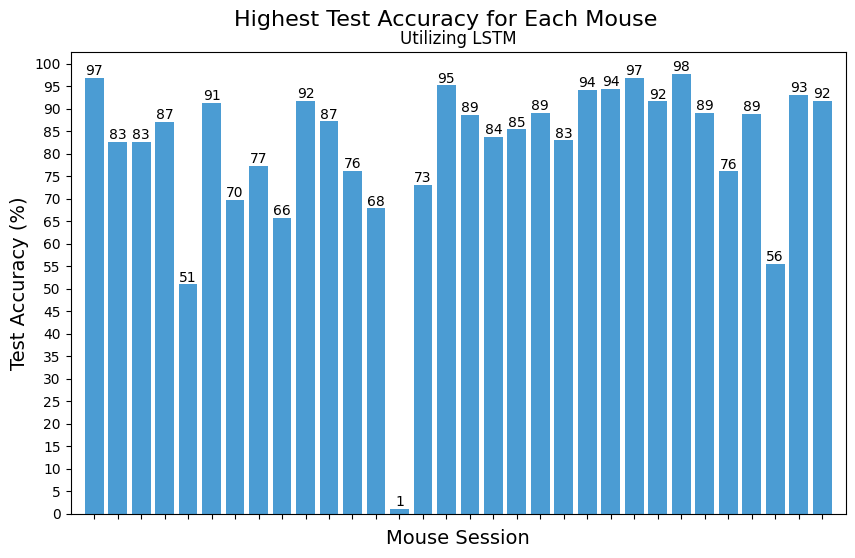

In [14]:
# Load the data
session_df = pd.read_csv('output/3_shot_LSTM_per_mouse.csv')

# Convert test_acc to numeric (if needed) and handle any non-numeric issues
session_df['test_acc'] = pd.to_numeric(session_df['test_acc'], errors='coerce')

# Filter the data to only show the highest test accuracy for each session and model
highest_acc_df = session_df.loc[session_df.groupby(['mouse_number', 'model'])['test_acc'].idxmax()]

# Extract the relevant columns
session_number = highest_acc_df['mouse_number']
test_acc = highest_acc_df['test_acc']
model_name = highest_acc_df['model']

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(session_number.astype(str), test_acc, color='#4B9CD3')  # Carolina blue color code

# Remove the x-axis label
plt.gca().xaxis.set_label_text('')

# Ensure y-axis ticks are correctly set
plt.yticks(np.arange(0, 100+1, 5))

# Set the y-axis label
plt.ylabel('Test Accuracy (%)', fontsize=14)

# Set the x-axis label
plt.xlabel('Mouse Session', fontsize=14)

# Adjust the plot to remove white space within the graph
plt.xlim(-1, len(session_number))

# Format y-axis ticks to show only to the hundredth decimal place
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}'.format(y)))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: ''.format(x)))

# Add the actual accuracy above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom')

# Add title and subtitle with less space
plt.suptitle('Highest Test Accuracy for Each Mouse', fontsize=16, y=0.95)
plt.title('Utilizing LSTM', fontsize=12, y=1)

# Show the plot
plt.xticks(rotation=90)

# Save the plot as a PNG file
plt.savefig('highest_test_accuracy.png', format='png')

# Display the plot
plt.show()


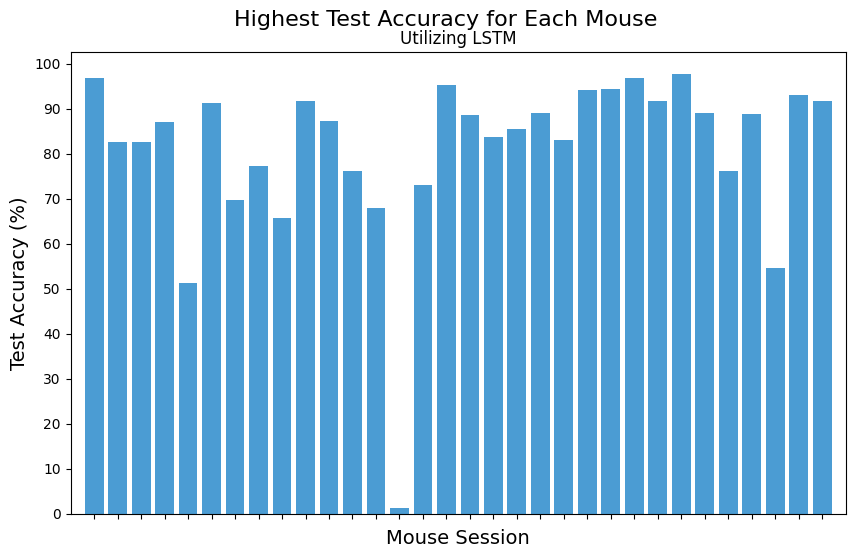

In [73]:
# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(session_number.astype(str), test_acc, color='#4B9CD3')  # Carolina blue color code

# Remove the x-axis label
plt.gca().xaxis.set_label_text('')

# Ensure y-axis ticks are correctly set
plt.yticks(np.arange(0, 100+1, 10))

# Set the y-axis label
plt.ylabel('Test Accuracy (%)', fontsize=14)

# Set the x-axis label
plt.xlabel('Mouse Session', fontsize=14)

# Adjust the plot to remove white space within the graph
plt.xlim(-1, len(session_number))

# Format y-axis ticks to show only to the hundredth decimal place
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}'.format(y)))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: ''.format(x)))

# Add title and subtitle with less space
plt.suptitle('Highest Test Accuracy for Each Mouse', fontsize=16, y=0.95)
plt.title('Utilizing LSTM', fontsize=12, y=1.0)

# Show the plot
plt.xticks(rotation=90)

# Save the plot as a PNG file
plt.savefig('highest_test_accuracy_no_subs.png', format='png')

# Display the plot
plt.show()